<a href="https://colab.research.google.com/github/iloElias/API_REST_Trabalho/blob/main/CopiaModeloRaioX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from string import Template
import os
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [10]:
print("You are using TensorFlow version", tf.__version__)
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("You have a GPU enabled.")
else:
    print("Enable a GPU before running this notebook.")

You are using TensorFlow version 2.15.0
You have a GPU enabled.


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
dataset_path_new = "/content/drive/MyDrive/Dataset/"

In [13]:
# Diretórios no Google Drive
healthy_dirs = [
    os.path.join(dataset_path_new, 'test', 'NORMAL'),
    os.path.join(dataset_path_new, 'train', 'NORMAL'),
    os.path.join(dataset_path_new, 'val', 'NORMAL')
]

pneumonia_bacteria_dir = [
    os.path.join(dataset_path_new, 'test', 'PNEUMONIA', 'BACTERIA'),
    os.path.join(dataset_path_new, 'train', 'PNEUMONIA', 'BACTERIA'),
    os.path.join(dataset_path_new, 'val', 'PNEUMONIA', 'BACTERIA')
]

pneumonia_virus_dir = [
    os.path.join(dataset_path_new, 'test', 'PNEUMONIA', 'VIRUS'),
    os.path.join(dataset_path_new, 'train', 'PNEUMONIA', 'VIRUS'),
    os.path.join(dataset_path_new, 'val', 'PNEUMONIA', 'VIRUS')
]

filepaths = []
labels = []
dict_lists = [healthy_dirs, pneumonia_bacteria_dir, pneumonia_virus_dir]
class_labels = ['Normal', 'Pneumonia Bacteriana', 'Pneumonia Viral']

for i, dir_list in enumerate(dict_lists):
    for directory in dir_list:
        flist = os.listdir(directory)
        for f in flist:
            fpath = os.path.join(directory, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
pneumonia_data = pd.concat([Fseries, Lseries], axis=1)
pneumonia_df = pd.DataFrame(pneumonia_data)
print(pneumonia_df.head())
print(pneumonia_df["labels"].value_counts())

                                           filepaths  labels
0  /content/drive/MyDrive/Dataset/test/NORMAL/IM-...  Normal
1  /content/drive/MyDrive/Dataset/test/NORMAL/IM-...  Normal
2  /content/drive/MyDrive/Dataset/test/NORMAL/IM-...  Normal
3  /content/drive/MyDrive/Dataset/test/NORMAL/IM-...  Normal
4  /content/drive/MyDrive/Dataset/test/NORMAL/IM-...  Normal
labels
Pneumonia Bacteriana    2784
Normal                  1583
Pneumonia Viral         1501
Name: count, dtype: int64


In [14]:
import os
import random
import pandas as pd

# Caminho do diretório do dataset
dataset_path_new = "/content/drive/MyDrive/Dataset/"

# Diretórios no Google Drive
healthy_dirs = [
    os.path.join(dataset_path_new, 'test', 'NORMAL'),
    os.path.join(dataset_path_new, 'train', 'NORMAL'),
    os.path.join(dataset_path_new, 'val', 'NORMAL')
]

pneumonia_bacteria_dir = [
    os.path.join(dataset_path_new, 'test', 'PNEUMONIA', 'BACTERIA'),
    os.path.join(dataset_path_new, 'train', 'PNEUMONIA', 'BACTERIA'),
    os.path.join(dataset_path_new, 'val', 'PNEUMONIA', 'BACTERIA')
]

pneumonia_virus_dir = [
    os.path.join(dataset_path_new, 'test', 'PNEUMONIA', 'VIRUS'),
    os.path.join(dataset_path_new, 'train', 'PNEUMONIA', 'VIRUS'),
    os.path.join(dataset_path_new, 'val', 'PNEUMONIA', 'VIRUS')
]

# Listas de diretórios
dict_lists = [healthy_dirs, pneumonia_bacteria_dir, pneumonia_virus_dir]

# Rótulos das classes
class_labels = ['Normal', 'Pneumonia Bacteriana', 'Pneumonia Viral']

filepaths = []
labels = []

# Percorrendo os diretórios e criando listas de caminhos de arquivo e rótulos
for i, dir_list in enumerate(dict_lists):
    for directory in dir_list:
        flist = os.listdir(directory)
        for f in flist:
            fpath = os.path.join(directory, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

# Criando um DataFrame do Pandas com os caminhos dos arquivos e os rótulos
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
pneumonia_data = pd.concat([Fseries, Lseries], axis=1)
pneumonia_df = pd.DataFrame(pneumonia_data)

# Contagem dos rótulos
print(pneumonia_df["labels"].value_counts())

# Determinando quantas imagens devem ser removidas
num_images_to_remove = len(pneumonia_df[pneumonia_df["labels"] == "Pneumonia Bacteriana"]) - len(pneumonia_df[pneumonia_df["labels"] == "Pneumonia Viral"])

# Removendo imagens aleatoriamente da categoria de Pneumonia Bacteriana
if num_images_to_remove > 0:
    pneumonia_bacteria_indices = pneumonia_df[pneumonia_df["labels"] == "Pneumonia Bacteriana"].index
    images_to_remove_indices = random.sample(list(pneumonia_bacteria_indices), num_images_to_remove)
    pneumonia_df = pneumonia_df.drop(images_to_remove_indices)

# Salvando o novo DataFrame
pneumonia_df.to_csv('/content/drive/MyDrive/Dataset/pneumonia_dataset_balanced.csv', index=False)
print("Número de imagens por classe após balanceamento:")
print(pneumonia_df["labels"].value_counts())


labels
Pneumonia Bacteriana    2784
Normal                  1583
Pneumonia Viral         1501
Name: count, dtype: int64
Número de imagens por classe após balanceamento:
labels
Normal                  1583
Pneumonia Bacteriana    1501
Pneumonia Viral         1501
Name: count, dtype: int64


In [15]:
print(pneumonia_df.head())
print(pneumonia_df["labels"].value_counts())

                                           filepaths  labels
0  /content/drive/MyDrive/Dataset/test/NORMAL/IM-...  Normal
1  /content/drive/MyDrive/Dataset/test/NORMAL/IM-...  Normal
2  /content/drive/MyDrive/Dataset/test/NORMAL/IM-...  Normal
3  /content/drive/MyDrive/Dataset/test/NORMAL/IM-...  Normal
4  /content/drive/MyDrive/Dataset/test/NORMAL/IM-...  Normal
labels
Normal                  1583
Pneumonia Bacteriana    1501
Pneumonia Viral         1501
Name: count, dtype: int64


In [16]:
pneumonia_df.shape

(4585, 2)

In [17]:
train_images, test_images = train_test_split(
    pneumonia_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(
    pneumonia_df, test_size=0.2, random_state=42)

In [18]:
train_dir = os.path.join(dataset_path_new, "train")
validation_dir = os.path.join(dataset_path_new, "validation")

In [19]:
image_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe=train_set, x_col="filepaths", y_col="labels",
                                      target_size=(224, 224),
                                      color_mode='rgb',
                                      class_mode="categorical",  # used for Sequential Model
                                      batch_size=4,
                                      shuffle=False  # do not shuffle data
                                      )
test = image_gen.flow_from_dataframe(dataframe=test_images, x_col="filepaths", y_col="labels",
                                     target_size=(224, 224),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle=False
                                     )
val = image_gen.flow_from_dataframe(dataframe=val_set, x_col="filepaths", y_col="labels",
                                    target_size=(224, 224),
                                    color_mode='rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                    )

Found 3668 validated image filenames belonging to 3 classes.
Found 1376 validated image filenames belonging to 3 classes.
Found 917 validated image filenames belonging to 3 classes.


In [20]:
classes = list(train.class_indices.keys())
print(classes)

['Normal', 'Pneumonia Bacteriana', 'Pneumonia Viral']


In [21]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels = next(image_gen)  # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length < 25:
        r = length
    else:
        r = 25
    for i in range(r):
        plt.subplot(5, 5, i+1)
        image = (images[i]+1)/2  # scale images between 0 and 1
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color="green", fontsize=16)
        plt.axis('off')
    plt.show()
    show_knee_images(train)

In [22]:
img_shape = (224, 224, 3)

In [23]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Flatten
# from tensorflow.keras.applications import DenseNet121

# # Defina o shape da imagem
# img_shape = (224, 224, 3)  # Por exemplo, 224x224 pixels com 3 canais de cor

# # Carregue o modelo DenseNet121 com pesos pré-treinados na ImageNet
# base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=img_shape)
# base_model.trainable = False

# # Crie um modelo sequencial
# model = Sequential()

# # Adicione o modelo DenseNet121 como uma camada ao modelo sequencial
# model.add(base_model)

# # Adicione uma camada de achatamento (flatten) para converter os mapas de características em um vetor unidimensional
# model.add(Flatten())

# # Adicione uma camada densa com 256 unidades e função de ativação ReLU
# model.add(Dense(256, activation='relu'))

# # Adicione uma camada de dropout para regularização
# model.add(Dropout(0.5))

# # Adicione a camada de saída com ativação softmax para classificação multiclasse
# model.add(Dense(len(classes), activation='softmax'))

# # Compile o modelo com otimizador Adam e função de perda de entropia cruzada categórica
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Imprima o resumo do modelo para verificar a arquitetura e os parâmetros
# model.summary()


In [24]:
# from tensorflow.keras.applications import DenseNet121

# base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=img_shape)
# base_model.trainable = False

# model = Sequential([
#     base_model,
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.5),
#     Dense(len(classes), activation='softmax')
# ])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [25]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# Definir número de classes
num_classes = 3

# Carregar a base ResNet50V2 pré-treinada
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=img_shape)

# Congelar os pesos da base
base_model.trainable = False

# Construir o modelo
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compilar o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

94668760/94668760 [==============================] - 0s 0us/step


In [26]:
# from tensorflow.keras.applications import VGG16

# base_model = VGG16(weights='imagenet', include_top=False, input_shape=img_shape)
# base_model.trainable = False

# model = Sequential([
#     base_model,
#     Flatten(),
#     Dense(256, activation='relu'),
#     Dropout(0.5),
#     Dense(len(classes), activation='softmax')
# ])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [27]:
import tensorflow as tf

# Definir e compilar o modelo
# Certifique-se de ter definido seu modelo antes desta parte do código
# Fitting do modelo
history = model.fit_generator(train,
                              epochs=20,
                              validation_data=val,
                              )


Epoch 1/20
917/917 [==============================] - 1734s 2s/step - loss: 0.8333 - accuracy: 0.6628 - val_loss: 0.5566 - val_accuracy: 0.7644
Epoch 2/20
917/917 [==============================] - 76s 83ms/step - loss: 0.6374 - accuracy: 0.7323 - val_loss: 0.5602 - val_accuracy: 0.7797
Epoch 3/20
917/917 [==============================] - 74s 81ms/step - loss: 0.6102 - accuracy: 0.7440 - val_loss: 0.5463 - val_accuracy: 0.7841
Epoch 4/20
917/917 [==============================] - 72s 78ms/step - loss: 0.5866 - accuracy: 0.7568 - val_loss: 0.4941 - val_accuracy: 0.8070
Epoch 5/20
917/917 [==============================] - 73s 79ms/step - loss: 0.5495 - accuracy: 0.7786 - val_loss: 0.5114 - val_accuracy: 0.7950
Epoch 6/20
917/917 [==============================] - 77s 84ms/step - loss: 0.5400 - accuracy: 0.7770 - val_loss: 0.5265 - val_accuracy: 0.7972
Epoch 7/20
917/917 [==============================] - 72s 79ms/step - loss: 0.5183 - accuracy: 0.7846 - val_loss: 0.5545 - val_accuracy:

In [28]:
model.evaluate(test, verbose=1)

344/344 [==============================] - 23s 65ms/step - loss: 0.5125 - accuracy: 0.8292


[0.5125290155410767, 0.8292151093482971]

In [29]:
from tensorflow.keras.models import model_from_json

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# Depois...
## load json and create model
with open('model.json', 'r') as json_file:
    loaded_model_json = json_file.read()

loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")


Saved model to disk
Loaded model from disk


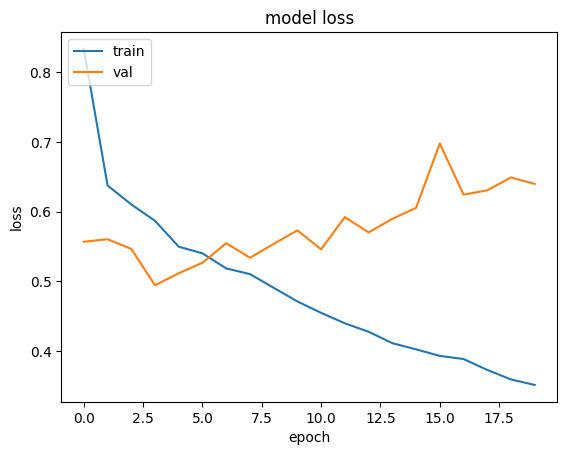

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Treinar o modelo (substitua X_train e y_train pelos seus dados de treinamento)
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Avaliar o modelo
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

# Prever classes para os dados de teste
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Exibir a matriz de confusão
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# Exibir relatório de classificação
print(classification_report(y_true, y_pred_classes))

NameError: name 'X_train' is not defined